In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Movie Recommendation based on K-Nearest-Neighbors

https://towardsdatascience.com/prototyping-a-recommender-system-step-by-step-part-1-knn-item-based-collaborative-filtering-637969614ea

In [2]:
!pip install fuzzywuzzy

In [3]:
import os
import time

# data science imports
import math
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

# utils import
from fuzzywuzzy import fuzz

# visualization imports
import seaborn as sns
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [4]:
df_movies = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/BigData_2020(2)/ml-latest-small/movies.csv', usecols=['movieId', 'title'])
df_movies.head()

,movieId,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)


In [5]:
df_ratings = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/BigData_2020(2)/ml-latest-small/ratings.csv', usecols=['userId', 'movieId', 'rating'])
df_ratings.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [6]:
num_users = len(df_ratings.userId.unique())
num_items = len(df_ratings.movieId.unique())
print('There are {} unique users and {} unique movies in this data set'.format(num_users, num_items))

There are 610 unique users and 9724 unique movies in this data set


In [7]:
df_ratings_cnt_tmp = pd.DataFrame(df_ratings.groupby('rating').size(), columns=['count'])
df_ratings_cnt_tmp

,count
rating,
0.5,1370
1.0,2811
1.5,1791
2.0,7551
2.5,5550
3.0,20047
3.5,13136
4.0,26818
4.5,8551


In [8]:
total_cnt = num_users * num_items

rating_zero_cnt = total_cnt - df_ratings.shape[0]
print('점수 안 매긴 갯수 :', rating_zero_cnt)
# append counts of zero rating to df_ratings_cnt
df_ratings_cnt = df_ratings_cnt_tmp.append(
    pd.DataFrame({'count': rating_zero_cnt}, index=[0.0]),
    verify_integrity=True,
).sort_index()
df_ratings_cnt

점수 안 매긴 갯수 : 5830804


,count
0.0,5830804
0.5,1370
1.0,2811
1.5,1791
2.0,7551
2.5,5550
3.0,20047
3.5,13136
4.0,26818
4.5,8551


In [9]:
# zero count가 너무 크므로 ln을 취해준다
# add log count
df_ratings_cnt['log_count'] = np.log(df_ratings_cnt['count'])
df_ratings_cnt

,count,log_count
0.0,5830804,15.578665
0.5,1370,7.222566
1.0,2811,7.941296
1.5,1791,7.490529
2.0,7551,8.929435
2.5,5550,8.621553
3.0,20047,9.905835
3.5,13136,9.483112
4.0,26818,10.196829
4.5,8551,9.053804


In [10]:
ex = df_ratings_cnt[['count']].reset_index().rename(columns={'index': 'rating score'})
ex

,rating score,count
0,0.0,5830804
1,0.5,1370
2,1.0,2811
3,1.5,1791
4,2.0,7551
5,2.5,5550
6,3.0,20047
7,3.5,13136
8,4.0,26818
9,4.5,8551


Text(0, 0.5, 'number of ratings')

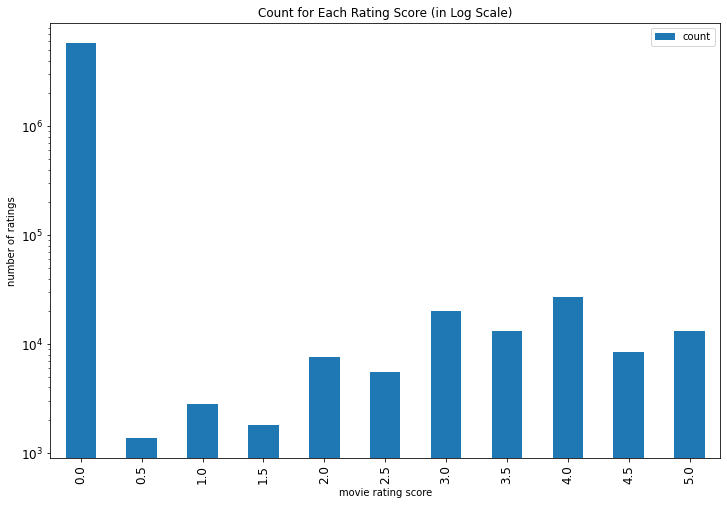

In [11]:
ax = df_ratings_cnt[['count']].reset_index().rename(columns={'index': 'rating score'}).plot(
    x='rating score',
    y='count',
    kind='bar',
    figsize=(12, 8),
    title='Count for Each Rating Score (in Log Scale)',
    logy=True,
    fontsize=12,
)
ax.set_xlabel("movie rating score")
ax.set_ylabel("number of ratings")

In [12]:
# get rating frequency
df_movies_cnt = pd.DataFrame(df_ratings.groupby('movieId').size(), columns=['count'])
df_movies_cnt.head()

,count
movieId,
1,215
2,110
3,52
4,7
5,49


Text(0, 0.5, 'number of ratings')

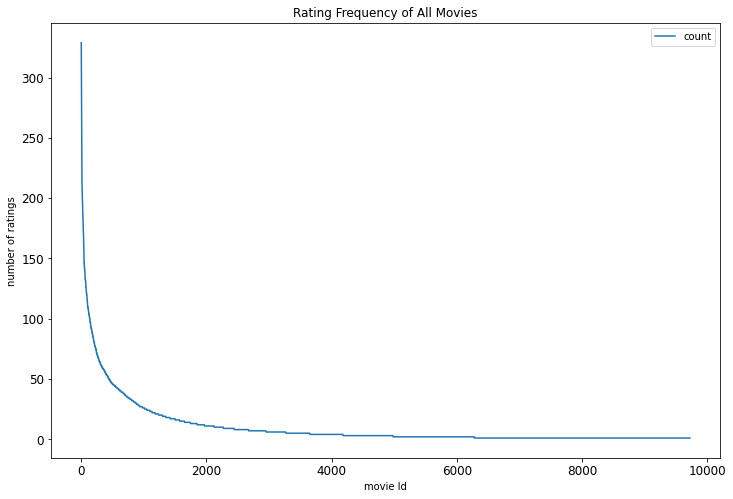

In [13]:
ax = df_movies_cnt.sort_values('count', ascending=False).reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Rating Frequency of All Movies',
        fontsize=12
    )
ax.set_xlabel("movie Id")
ax.set_ylabel("number of ratings")

Text(0, 0.5, 'number of ratings (log scale)')

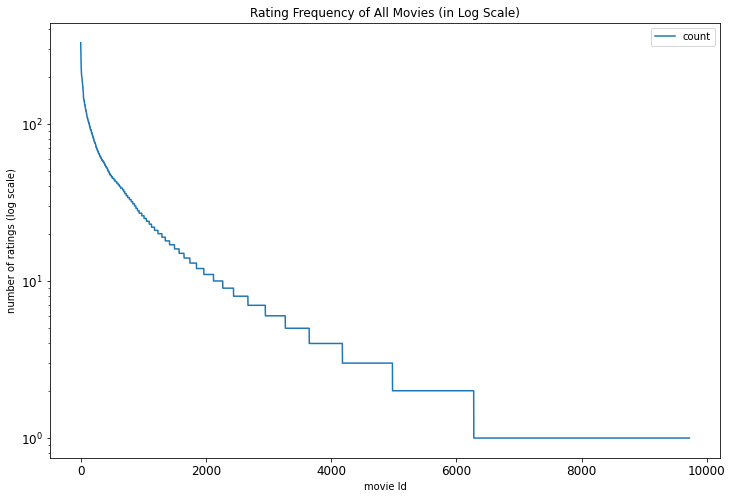

In [14]:
# plot rating frequency of all movies in log scale
ax = df_movies_cnt \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Rating Frequency of All Movies (in Log Scale)',
        fontsize=12,
        logy=True
    )
ax.set_xlabel("movie Id")
ax.set_ylabel("number of ratings (log scale)")

In [15]:
df_movies_cnt['count'].quantile(np.arange(1, 0.6, -0.05))

# 상위 1%가 329개 평가를 받았고
# 상위 5%는 47개 평가
# 상위 20% 아래는 10개 이하의 평가를 기록

1.00    329.0
0.95     47.0
0.90     27.0
0.85     17.0
0.80     12.0
0.75      9.0
0.70      7.0
0.65      5.0
Name: count, dtype: float64

In [16]:
# filter data
popularity_thres = 10
popular_movies = list(set(df_movies_cnt.query('count >= @popularity_thres').index))
df_ratings_drop_movies = df_ratings[df_ratings.movieId.isin(popular_movies)]
print('shape of original ratings data: ', df_ratings.shape)
print('shape of ratings data after dropping unpopular movies: ', df_ratings_drop_movies.shape)
df_ratings_drop_movies.head()

shape of original ratings data:  (100836, 3)
shape of ratings data after dropping unpopular movies:  (81116, 3)


,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [17]:
df_users_cnt = pd.DataFrame(df_ratings_drop_movies.groupby('userId').size(), columns=['count'])
df_users_cnt.head()

,count
userId,
1,211
2,26
3,24
4,179
5,44


Text(0, 0.5, 'number of ratings')

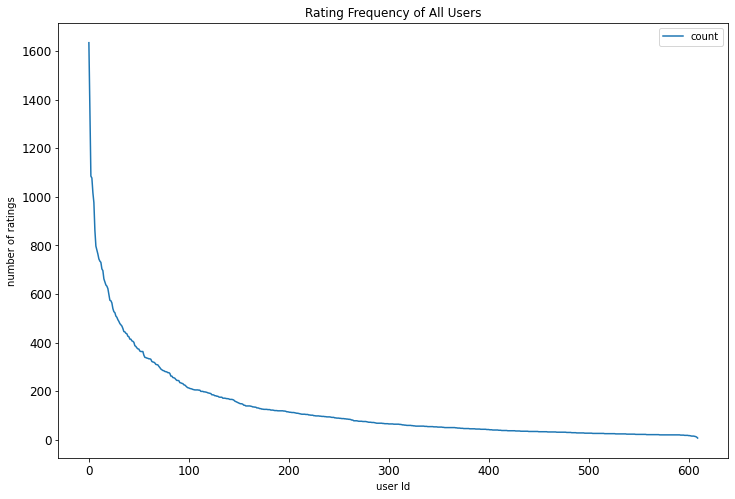

In [18]:
# plot rating frequency of all movies
ax = df_users_cnt \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Rating Frequency of All Users',
        fontsize=12
    )
ax.set_xlabel("user Id")
ax.set_ylabel("number of ratings")

In [19]:
df_users_cnt['count'].quantile(np.arange(1, 0.2, -0.05))

# 상위 1%는 1600개 평가
# 상위 5%는 482개 평가

1.00    1634.00
0.95     482.95
0.90     333.00
0.85     234.65
0.80     190.20
0.75     148.00
0.70     122.00
0.65     105.00
0.60      92.00
0.55      75.00
0.50      64.50
0.45      56.00
0.40      50.00
0.35      43.00
0.30      36.70
0.25      33.00
Name: count, dtype: float64

In [20]:
# filter data
# 50개이상
ratings_thres = 50
active_users = list(set(df_users_cnt.query('count >= @ratings_thres').index))
df_ratings_drop_users = df_ratings_drop_movies[df_ratings_drop_movies.userId.isin(active_users)]
print('shape of original ratings data: ', df_ratings.shape)
print('shape of drop unpopular movies: ', df_ratings_drop_movies.shape)
print('shape of ratings data after dropping both unpopular movies and inactive users: ', df_ratings_drop_users.shape)
df_ratings_drop_users.head()

shape of original ratings data:  (100836, 3)
shape of drop unpopular movies:  (81116, 3)
shape of ratings data after dropping both unpopular movies and inactive users:  (73868, 3)


,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [21]:
# pivot and create movie-user matrix
movie_user_mat = df_ratings_drop_users.pivot(index='movieId', columns='userId', values='rating').fillna(0)
movie_user_mat.head()

userId,1,4,6,7,10,11,15,16,17,18,19,20,21,22,23,24,27,28,29,32,33,34,36,38,39,40,41,42,43,45,47,50,51,52,57,58,59,62,63,64,...,559,560,561,562,563,564,566,567,570,571,572,573,577,579,580,582,583,584,585,586,587,588,590,591,592,593,594,596,597,599,600,601,602,603,604,605,606,607,608,610
movieId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,4.5,0.0,0.0,2.5,0.0,4.5,3.5,4.0,0.0,3.5,0.0,0.0,0.0,3.0,0.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,5.0,4.0,0.0,3.0,0.0,0.0,5.0,0.0,0.0,0.0,5.0,4.0,...,5.0,3.0,4.0,4.5,0.0,0.0,0.0,3.5,4.0,0.0,4.0,5.0,0.0,4.0,3.0,0.0,0.0,5.0,0.0,0.0,5.0,0.0,4.0,0.0,0.0,0.0,0.0,4.0,4.0,3.0,2.5,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,5.0
2,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,3.0,3.5,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.5,0.0,0.0,0.0,0.0,4.0,0.0,0.0,...,4.0,0.0,4.0,0.0,2.5,0.0,4.0,0.0,3.5,0.0,0.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,2.5,0.0,4.0,0.0,4.0,0.0,0.0,2.5,4.0,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0
3,4.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,3.0,0.0,0.0,0.0,3.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,0.0,0.0,0.0,4.0,0.0,0.0,1.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
5,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,3.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.5,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
6,4.0,0.0,4.0,0.0,0.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,4.0,4.5,0.0,3.5,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,4.5,0.0,4.5,...,5.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.5,4.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,3.5,0.0,3.0,0.0,0.0,0.0,3.0,4.5,0.0,0.0,3.0,4.0,3.0,0.0,0.0,0.0,0.0,5.0


In [22]:
# create mapper from movie title to index
movie_to_idx = {
    movie: i for i, movie in 
    enumerate(list(df_movies.set_index('movieId').loc[movie_user_mat.index].title))
}
# transforfm matrix to scipy sparse matrix
movie_user_mat_sparse = csr_matrix(movie_user_mat.values)

In [23]:
#n_jobs = cpu사용갯수, -1시 최대
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=10, n_jobs=-1)
model_knn.fit(movie_user_mat_sparse)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=-1, n_neighbors=10, p=2,
                 radius=1.0)

In [24]:
def fuzzy_matching(mapper, fav_movie, verbose=True):
    """
    return the closest match via fuzzy ratio. If no match found, return None
    
    Parameters
    ----------    
    mapper: dict, map movie title name to index of the movie in data

    fav_movie: str, name of user input movie
    
    verbose: bool, print log if True

    Return
    ------
    index of the closest match
    """
    match_tuple = []
    # get match
    for title, idx in mapper.items():
        ratio = fuzz.ratio(title.lower(), fav_movie.lower())
        if ratio >= 60:
            match_tuple.append((title, idx, ratio))
    # sort
    match_tuple = sorted(match_tuple, key=lambda x: x[2])[::-1]
    if not match_tuple:
        print('Oops! No match is found')
        return
    if verbose:
        print('Found possible matches in our database: {0}\n'.format([x[0] for x in match_tuple]))
    return match_tuple[0][1]



def make_recommendation(model_knn, data, mapper, fav_movie, n_recommendations):
    """
    return top n similar movie recommendations based on user's input movie


    Parameters
    ----------
    model_knn: sklearn model, knn model

    data: movie-user matrix

    mapper: dict, map movie title name to index of the movie in data

    fav_movie: str, name of user input movie

    n_recommendations: int, top n recommendations

    Return
    ------
    list of top n similar movie recommendations
    """
    # fit
    model_knn.fit(data)
    # get input movie index
    print('You have input movie:', fav_movie)
    idx = fuzzy_matching(mapper, fav_movie, verbose=True)
    # inference
    print('Recommendation system start to make inference')
    print('......\n')
    distances, indices = model_knn.kneighbors(data[idx], n_neighbors=n_recommendations+1)
    # get list of raw idx of recommendations
    raw_recommends = \
        sorted(list(zip(indices.squeeze().tolist(), distances.squeeze().tolist())), key=lambda x: x[1])[:0:-1]
    # get reverse mapper
    reverse_mapper = {v: k for k, v in mapper.items()}
    # print recommendations
    print('Recommendations for {}:'.format(fav_movie))
    for i, (idx, dist) in enumerate(raw_recommends):
        print('{0}: {1}, with distance of {2}'.format(i+1, reverse_mapper[idx], dist))

In [25]:
my_favorite = 'Iron Man'

make_recommendation(
    model_knn=model_knn,
    data=movie_user_mat_sparse,
    fav_movie=my_favorite,
    mapper=movie_to_idx,
    n_recommendations=10)

You have input movie: Iron Man
Found possible matches in our database: ['Iron Man (2008)', 'Iron Man 3 (2013)', 'Iron Man 2 (2010)']

Recommendation system start to make inference
......

Recommendations for Iron Man:
1: Guardians of the Galaxy (2014), with distance of 0.36458591835521437
2: Watchmen (2009), with distance of 0.364385175658941
3: Star Trek (2009), with distance of 0.36183954974701704
4: Inception (2010), with distance of 0.3600731056489729
5: Up (2009), with distance of 0.35088208398996457
6: Avatar (2009), with distance of 0.306339016530641
7: Iron Man 2 (2010), with distance of 0.30291483139956044
8: WALL·E (2008), with distance of 0.29827569654656105
9: Dark Knight, The (2008), with distance of 0.28361385176071996
10: Avengers, The (2012), with distance of 0.273085267898582


# Surprise 적용

In [28]:
print('shape of original ratings data: ', df_ratings.shape)
print('shape of drop unpopular movies: ', df_ratings_drop_movies.shape)
print('shape of ratings data after dropping both unpopular movies and inactive users: ', df_ratings_drop_users.shape)
df_ratings_drop_users.head()

shape of original ratings data:  (100836, 3)
shape of drop unpopular movies:  (81116, 3)
shape of ratings data after dropping both unpopular movies and inactive users:  (73868, 3)


,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [ ]:
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split

reader = Reader(rating_scale=(0.5, 5))

data = Dataset.load_from_df(df_ratings_drop_users[['userId', 'movieId', 'rating']], reader=reader)
train, test = train_test_split(data, test_size=0.25, random_state=42)
